# **Deep Learning model**

This notebook shows an attempt to predict ups or downs in the 
price of BTC during day following randomly sampled sequences of consequtive days

In [1]:
# Dataframe and its manipulations
import pandas as pd

# Array manipulations
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Plotting
import matplotlib.pyplot as plt

# Indicators from talib
import talib
from talib import RSI, WILLR, CDLDOJI, CDLHAMMER, CDLHANGINGMAN, NATR, ADOSC, MOM

# Deep learning model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Date time
from datetime import datetime

### DATA PREPARATION

In this algorithm, we tried to include the close of the NASDAQ and the 
close of the S&P for each day. This was done to identify potential spillover
effects between the BTC and the traditional financial markets. Overall, this
addition improved our results.

In [2]:
# Handling of data NASDAQ
data_nasdaq=pd.read_csv("/Users/Axel/Desktop/HistoricalPricesNASDAQ.csv")

# Only keep the desired columns
data_nasdaq = data_nasdaq[["Date"," Close"]]

# Rename the column
data_nasdaq["Close Nasdaq"] = data_nasdaq[" Close"]

# Drop the Close column
data_nasdaq=data_nasdaq.drop(columns=[" Close"])

# Convert the date to datetye format
data_nasdaq['Date'] = data_nasdaq['Date'].astype('datetime64[ns]')


# Inverse the order of the data to have the oldest first
data_nasdaq=data_nasdaq.reindex(index=data_nasdaq.index[::-1])


# Handling of data S&P
data_sp = pd.read_csv("/Users/Axel/Desktop/HistoricalPricesS&P.csv")

# Only keep the desired columns
data_sp = data_sp[["Date"," Close"]]

# Rename the column
data_sp["Close S&P"] = data_sp[" Close"]

# Drop the Close column
data_sp=data_sp.drop(columns=[" Close"])

# Inverse the order of the data to have the oldest first
data_sp=data_sp.reindex(index=data_sp.index[::-1])

# Convert the date to datetye format
data_sp['Date'] = data_sp['Date'].astype('datetime64[ns]')

In [3]:
# Have a look
data_nasdaq.head()

,Date,Close Nasdaq
1276,2017-06-01,6246.83
1275,2017-06-02,6305.80
1274,2017-06-05,6295.68
1273,2017-06-06,6275.06
1272,2017-06-07,6297.38


In [4]:
# Have a look
data_sp.head()

,Date,Close S&P
1276,2017-06-01,2430.06
1275,2017-06-02,2439.07
1274,2017-06-05,2436.10
1273,2017-06-06,2429.33
1272,2017-06-07,2433.14


### Handling of the combined S&P and Nasdaq and and address the issue that there is no data for the closes during weekend.

Create an empty dataframe with only date the correspond to our period 
of interest (here starting in summer 2017 after the launch of binance). This df
will also include the weekends

In [5]:
# Create dataframe
date_df=pd.DataFrame(pd.date_range(start="2017-08-21",end="2022-05-27"),columns=["Date"])

# Merge the data from nasdaq and s&p with the date data frame
date_df=date_df.merge(data_sp,on="Date",how="left")
date_df=date_df.merge(data_nasdaq,on="Date",how="left")

# Use the "ffill" method to fill the n/a (closes values during the weekends) with the last non n/a values
date_df=date_df.fillna(method="ffill")

In [6]:
# Handling of the BTC data
data=pd.read_csv("/Users/Axel/code/a4xel/Projet/nlp_predict_bitcoin_pricing/data/BTC_Dataframe_daily.csv")

# Create a new column populated by the movement during the day
data["Movement_daily"] = data["Close"] - data["Open"]

# Create our binary response variable which corresponds has 1 if the movement during the day is positive and 0 if negative
data["Movement_daily_binary"] = [1 if i > 0 else -1 for i in data["Movement_daily"]]
data.dropna(inplace=True)
data.head()


,Date,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary
0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,10.095993,1
1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,-5.000000,-1
2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,-22.010002,-1
3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,-11.169998,-1
4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,-8.500000,-1


### Add Talib indicators

In [7]:
# Handling of the technical indicators using the TALIB library (see the read.me file for more details)
data["RSI"]= RSI(data["Close"], timeperiod=13)
data["WILLR"] = WILLR(data["High"],data["Low"], data["Close"],timeperiod=14)
data["CDLDOJI"] = CDLDOJI(data["Open"],data["High"],data["Low"],data["Close"])
data["CDLHAMMER"] = CDLHAMMER(data["Open"],data["High"],data["Low"],data["Close"])
data["CDLHANGINGMAN"] = CDLHANGINGMAN(data["Open"],data["High"],data["Low"],data["Close"])
data["NATR"] = NATR(data["High"],data["Low"], data["Close"],timeperiod=13)
data["ADOSC"] = ADOSC(data["High"],data["Low"],data["Close"],data["Volume"],fastperiod=3, slowperiod=10)
data["MOM"] = MOM(data["Close"], timeperiod = 14)

### Merge the dataframes

In [8]:
# Merging the dataframes,removing the NAs and setting the period, removing the date column to allow scaling
data=data.dropna()

# Convert date as datetype to allow merging
data['Date'] = data['Date'].astype('datetime64[ns]')

# Merge BTC data with the Nasdaq and S&P data
data=data.merge(date_df,on="Date",how="left")

# Select only the data during our period of interest
mask = pd.to_datetime(data['Date']) > '20/08/2017'
data=data[mask]
data=data.drop(columns=["Date"])
data.head()

,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary,RSI,WILLR,CDLDOJI,CDLHAMMER,CDLHANGINGMAN,NATR,ADOSC,MOM,Close S&P,Close Nasdaq
1561,4119.62,3911.79,4069.13,4016.00,691.743060,-53.13,-1,63.326886,-37.923761,0,0,0,6.640422,1.751012e+09,637.060059,2428.37,6213.13
1562,4104.82,3400.00,4016.00,4040.00,966.684858,24.00,1,63.905333,-35.984712,100,0,0,7.435210,1.447901e+09,620.060059,2452.51,6297.48
1563,4265.80,4013.89,4040.00,4114.01,1001.136565,74.01,1,65.712083,-31.852957,0,0,0,7.210820,1.192274e+09,771.540029,2444.04,6278.41
1564,4371.68,4085.01,4147.00,4316.01,787.418753,169.01,1,70.132622,-15.214640,0,0,0,6.855541,9.793105e+08,934.729971,2438.97,6271.33
1565,4453.91,4247.48,4316.01,4280.68,573.612740,-35.33,-1,68.460273,-18.860502,100,0,0,6.751372,8.031608e+08,630.059883,2443.05,6265.64


### Split the data into train and test sets

In [9]:
# We split the dataset into a train and a test set 
# We realize the split at 90% to maximize the training data
len = int(0.9*data.shape[0])
df_train = data[:len]
df_test = data[len:]

### DATA SCALING

In [10]:
# Scaling the Data Frames and retrieving the column names

# We use a MinMax scaler to scale our data
scaler = MinMaxScaler(feature_range=(0,1))

# We scale the train and test data
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

# As the minmaxscaler erases the columns, we set our scaled data as dataframes and we give them them column names of the unscaled data frames
df_train_scale_DF = pd.DataFrame(df_train_scaled)
df_train_scale_DF.columns=df_train.columns
df_test_scaled_DF = pd.DataFrame(df_test_scaled)
df_test_scaled_DF.columns=df_test.columns

In [11]:
# Have a look
df_train_scale_DF.head()

,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary,RSI,WILLR,CDLDOJI,CDLHAMMER,CDLHANGINGMAN,NATR,ADOSC,MOM,Close S&P,Close Nasdaq
0,0.012828,0.017267,0.013695,0.012854,0.001153,0.477878,0.0,0.636089,0.618054,0.0,0.0,1.0,0.245058,1.000000,0.574017,0.077405,0.002049
1,0.012603,0.009195,0.012869,0.013227,0.001837,0.483155,1.0,0.642938,0.637628,1.0,0.0,1.0,0.285807,0.826902,0.573614,0.087190,0.010600
2,0.015052,0.018877,0.013242,0.014377,0.001923,0.486576,1.0,0.664332,0.679338,0.0,0.0,1.0,0.274302,0.680921,0.577204,0.083757,0.008666
3,0.016663,0.019998,0.014906,0.017517,0.001391,0.493075,1.0,0.716675,0.847301,0.0,0.0,1.0,0.256087,0.559304,0.581071,0.081702,0.007949
4,0.017915,0.022561,0.017532,0.016968,0.000860,0.479096,0.0,0.696873,0.810496,1.0,0.0,1.0,0.250746,0.458710,0.573851,0.083356,0.007372


### DATA SAMPLING

The following functions are used to create random sequences of consequtive days.
We can choose the number of sequences we want to sample as well as the 
number of days in each sequence. The functions then randomly selects sequences 
in the data set. The y list is populated with the response variable. In this case,
this variable can be found in the "Movement_daily_binary" column and has 1 if 
the BTC went up in a period and 0 if it went down. For each sequence, the function
selects the movement for the day that follows the last day of the sequence. Hence,
our algorithm can be trained to predict the movement of next period with data 
from the past. Finally, the function returns arrays in a shape suitable to be 
used in a LSTM or GRU model

In [12]:
# Functions
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    return df_sample

def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['Movement_daily_binary']

    X_sample = df_subsample[0:length -1]
    X_sample = X_sample.values
    return np.array(X_sample), np.array(y_sample)


def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    return X, y

We use the previously defined function to get X and y both in the train and
test sets. We check that the shape is compatible with the shape expected by the
neural networks

In [13]:
# Use the functions on the df
X_train, y_train = get_X_y(df_train_scale_DF, 500, 31)
X_test, y_test = get_X_y(df_test_scaled_DF, 6, 31)
X_train.shape

(500, 30, 17)

### MODELLING

We create a function that defines the model
Here GRU is used as it led to more satisfactory results than LSTM
In addition, we use one dropoutlayer to prevent overfitting
The rmsprop optimizer also led to better results than adam
the binary crossentropy loss function results from the binary classification task

In [14]:
# Function to init NN
def initialize__compile_model():
    model = Sequential()
    model.add(layers.GRU(units=36,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[-1]),activation="tanh"))
    model.add(layers.GRU(units=36,return_sequences=False,activation="tanh"))
    model.add(layers.Dropout(0.4))
    model.add(Dense(units=10,activation="relu"))
    model.add(Dense(units=1,activation="sigmoid"))
    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model

We set an early stopping criteria to prevent overfitting and Instantiate 
and run the model with a validation split

In [15]:
# Add EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100, restore_best_weights=True)

# Init model
model=initialize__compile_model()

# Fit the model
history=model.fit(X_train,y_train,epochs=200,batch_size=16,validation_split=0.2,callbacks=[es])

2022-06-28 17:24:40.147610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 17:24:40.441359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
25/25 [==============================] - 2s 33ms/step - loss: 0.7114 - accuracy: 0.4750 - val_loss: 0.6879 - val_accuracy: 0.5600
Epoch 2/200
25/25 [==============================] - 0s 14ms/step - loss: 0.6959 - accuracy: 0.5050 - val_loss: 0.6905 - val_accuracy: 0.5400
Epoch 3/200
25/25 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.5100 - val_loss: 0.6995 - val_accuracy: 0.5000
Epoch 4/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6892 - accuracy: 0.5100 - val_loss: 0.7040 - val_accuracy: 0.4300
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5775 - val_loss: 0.6858 - val_accuracy: 0.5800
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5300 - val_loss: 0.7092 - val_accuracy: 0.5000
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5600 - val_loss: 0.7231 - val_accuracy: 0.4000
Epoch 8/20

### RESULTS

We define the following function to visuliize the loss function and the
accuracy for each epoch between the training set and the validation set

In [16]:
# Plot the accuracy
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

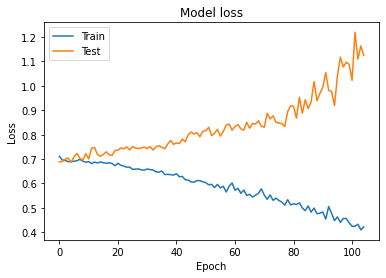

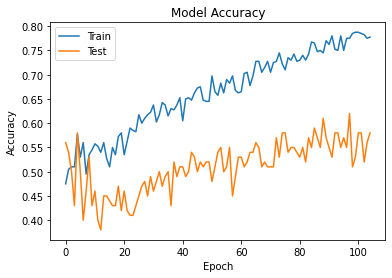

In [17]:
# Plot the history with the aforementioned function
plot_loss_accuracy(history)

Note : Here we clearly see some overfitting. On the one hand, the accuracy of the train set keeps increasing while the 
loss keeps diminishing. On the other hand, the accuracy of the validation set plateaus around 0.55 and the loss functions starts
going up after 80 epochs.

In [18]:
# We evaluate the model on the test set
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 12ms/step - loss: 0.6668 - accuracy: 0.8333


[0.6668335795402527, 0.8333333134651184]

### Exploration to see if stationarizing the data leads to better results

Now we try to stationarize the data in addition to scaling them
to see if we obtain different results.

In [19]:
# Scaling the Data Frames and retrieving the column names

# We use a MinMax scaler to scale our data
scaler = MinMaxScaler(feature_range=(0,1))

# We scale the train and test data
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

# As the minmaxscaler erases the columns, we set our scaled data as dataframes and we give them them column names of the unscaled data frames
df_train_scale_DF = pd.DataFrame(df_train_scaled)
df_train_scale_DF.columns=df_train.columns
df_train_scale_DF=df_train_scale_DF.diff()
df_train_scale_DF.dropna(inplace=True)
df_test_scaled_DF = pd.DataFrame(df_test_scaled)
df_test_scaled_DF.columns=df_test.columns
df_test_scaled_DF=df_test_scaled_DF.diff()
df_test_scaled_DF.dropna(inplace=True)

In [20]:
# Use the functions on the df
X_train, y_train = get_X_y(df_train_scale_DF, 500, 31)
X_test, y_test = get_X_y(df_test_scaled_DF, 6, 31)
X_train.shape

(500, 30, 17)

In [21]:
# Function to init model with news number of units
def initialize__compile_model():
    model = Sequential()
    model.add(layers.GRU(units=20,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[-1]),activation="tanh"))
    model.add(layers.GRU(units=20,return_sequences=True,activation="tanh"))
    model.add(layers.Dropout(0.4))
    model.add(Dense(units=10,activation="relu"))
    model.add(Dense(units=1,activation="sigmoid"))
    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100, restore_best_weights=True)

# Init model
model=initialize__compile_model()

# Fit the model
history=model.fit(X_train,y_train,epochs=200,batch_size=16,validation_split=0.2,callbacks=[es])

Epoch 1/200
25/25 [==============================] - 2s 22ms/step - loss: 0.5061 - accuracy: 0.4689 - val_loss: 0.2359 - val_accuracy: 0.4500
Epoch 2/200
25/25 [==============================] - 0s 8ms/step - loss: -0.0027 - accuracy: 0.4725 - val_loss: -0.0804 - val_accuracy: 0.4500
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: -0.1923 - accuracy: 0.4725 - val_loss: -0.1557 - val_accuracy: 0.4500
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: -0.2704 - accuracy: 0.4725 - val_loss: -0.2075 - val_accuracy: 0.4500
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: -0.3259 - accuracy: 0.4725 - val_loss: -0.2470 - val_accuracy: 0.4500
Epoch 6/200
25/25 [==============================] - 0s 8ms/step - loss: -0.3852 - accuracy: 0.4725 - val_loss: -0.2762 - val_accuracy: 0.4500
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: -0.4281 - accuracy: 0.4725 - val_loss: -0.3057 - val_accuracy: 0.4500


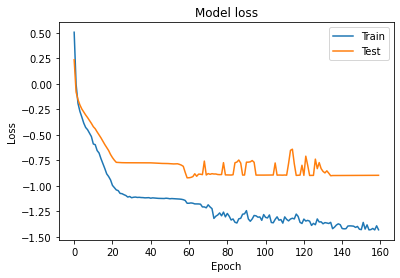

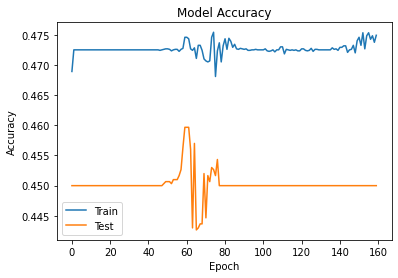

In [23]:
# Plot the accuracy
plot_loss_accuracy(history)

In [24]:
# Evaluate the model
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 12ms/step - loss: 2.6046 - accuracy: 0.4500


[2.6046407222747803, 0.45000001788139343]

Here, we also see overfitting with the loss functions which starts after 60 epochs